# **Test 010424**





In [ ]:
import pandas as pd

In [ ]:
def read_data(file_path):
    """
       params:
           file_path: 文件路径
       return:
           data: 读取的数据列表，每行一条样本

    """
    data = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            # 过长的评论文本会超出io限制报错。 暂时忽略
            try:
                # 字符串预处理
                # 布尔替换成python的习惯
                str_text = line.replace("true", "True")
                str_text = str_text.replace("false", "False")
                # 转成字典形式
                raw_sample = eval(str_text)
                data.append([raw_sample['reviewerID'],
                             raw_sample['asin'],
                             raw_sample['overall'],
                             raw_sample['reviewText']])
            except:
                pass
    return data


In [ ]:
data = read_data("./data/raw/Beauty_5.json")
data_df = pd.DataFrame(data)
data_df.columns = ['reviewerID', 'asin', 'overall', 'reviewText']
data = data_df["reviewText"].tolist()

In [ ]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel

model_name='bert-base-uncased'
# Khởi tạo tokenizer và model BERT
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
def extract_bert_features(text, model, tokenizer, output_dim=10):


    # Tokenize văn bản và thêm token '[CLS]' và '[SEP]'
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    # Feed-forward văn bản qua model BERT để trích xuất đặc trưng
    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy đặc trưng từ lớp embedding (lớp cuối cùng trước lớp softmax)
    features = outputs.last_hidden_state

    # Pooling các đặc trưng từ các token thành một vector đặc trưng (ở đây ta sử dụng mean pooling)
    pooled_features = torch.mean(features, dim=1)  # Kích thước: (1, hidden_size)

    # Giảm chiều feature đầu ra bằng cách sử dụng một lớp Linear
    linear_layer = torch.nn.Linear(pooled_features.shape[1], output_dim)
    reduced_features = linear_layer(pooled_features)

    return reduced_features

# Tính cosine similarity
def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2).item()

# Tính Euclidean distance
def euclidean_distance(vec1, vec2):
    return torch.dist(vec1, vec2).item()



In [ ]:
# # Sử dụng hàm để trích xuất đặc trưng từ văn bản
# text = "Hello"
# features = extract_bert_features(text, model, tokenizer)
# print(features)

# # Sử dụng hàm để trích xuất đặc trưng từ văn bản
# text = "Hello"
# features = extract_bert_features(text, model, tokenizer)
# print(features)

# Ví dụ về sử dụng
text1 = "Hello, how are you?"
text2 = "Hi, how are you doing?"
features1 = extract_bert_features(text1, model, tokenizer)
features2 = extract_bert_features(text2, model, tokenizer)


print("Cosine similarity:", cosine_similarity(features1, features2))
print("Euclidean distance:", euclidean_distance(features1, features2))

Cosine similarity: -0.2672140598297119
Euclidean distance: 1.078762173652649


In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, Dataset

# Tạo dataset đơn giản
train_data = [
    {'text': 'This is a positive sentence.', 'label': 1},
    {'text': 'I love using BERT for natural language processing tasks.', 'label': 1},
    {'text': 'Negative sentiment is not good for the mood.', 'label': 0},
    {'text': 'The quick brown fox jumps over the lazy dog.', 'label': 1},
    {'text': 'I am not feeling well today.', 'label': 0}
]

# Chuẩn bị dữ liệu huấn luyện
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label)
        }

# Chuẩn bị mô hình BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Fine-tuning mô hình
train_dataset = CustomDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 3
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

# Lưu mô hình sau khi fine-tune
model.save_pretrained("fine_tuned_bert_model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.6994596719741821
Epoch 2, Loss: 0.42255306243896484
Epoch 3, Loss: 0.3985089808702469


In [ ]:
# Load mô hình và tokenizer đã fine-tune
model = BertForSequenceClassification.from_pretrained("fine_tuned_bert_model")
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Chuẩn bị câu văn bản để test
text = "This is a positive sentence."

# Tokenize câu văn bản
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

# Phân loại hoặc trích xuất đặc trưng từ câu văn bản
with torch.no_grad():
    outputs = model(**inputs)

# Nếu muốn phân loại, sử dụng logits
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()
print("Predicted class:", predicted_class)

# Nếu muốn trích xuất đặc trưng, sử dụng đặc trưng từ lớp embedding (lớp cuối cùng trước lớp softmax)
features = outputs.last_hidden_state.mean(dim=1).squeeze(0)  # Sửa đoạn này
print("Extracted features:", features)

OSError: Can't load tokenizer for 'fine_tuned_bert_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'fine_tuned_bert_model' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.

In [ ]:
import pandas as pd

data = read_data("/content/drive/MyDrive/Recommandation System/AMAZON_FASHION_5.json")
data_df = pd.DataFrame(data)
data_df.columns = ['reviewerID', 'asin', 'overall', 'reviewText']
data = data_df["reviewText"].tolist()
# In kết quả xuống hàng mỗi record
for record in data[:20]:  # Chỉ in 20 record đầu tiên
    print(record)

Great product and price!
Great product and price!
Great product and price!
Great product and price!
Great product and price!
Waaay too small. Will use for futur children!
Stays vibrant after many washes
Stays vibrant after many washes
My son really likes the pink. Ones which I was nervous about
Waaay too small. Will use for future child.
Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These were recommended by my Podiatrist.
This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neuromas. Unfortunately, the ones I ordered from SmartDestination must be seconds as they kill my feet. The hard plastic insert rubs on the outside edges of my feet. I am unable to exchange them as I waited one day too late to use them in my walking shoes.
We have used these inserts for years.  They provide great support.
Pinnacle seems to have more cushioning so my husband likes them better. He's tried all the other Powerstep insert

In [ ]:
from nltk.corpus import wordnet, stopwords
from collections import Counter
import re
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

def preprocess_text(text):
    # Loại bỏ ký tự không cần thiết và chuyển đổi thành chữ thường
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def get_common_words(texts, n):
    # Tiền xử lý văn bản và loại bỏ từ dừng
    preprocessed_texts = [remove_stopwords(preprocess_text(text)) for text in texts]

    # Tách thành các từ riêng lẻ
    words = ' '.join(preprocessed_texts).split()

    # Đếm tần suất của các từ
    word_counts = Counter(words)

    # Chọn các từ có tần suất xuất hiện cao nhất
    common_words = [word for word, count in word_counts.most_common(n)]

    return common_words

def convert_records_to_dataset(records):
    dataset_words = []
    for record in records:
        # Tiền xử lý văn bản
        preprocessed_text = preprocess_text(record)

        # Loại bỏ các từ dừng
        filtered_words = remove_stopwords(preprocessed_text)

        # Thêm các từ vào dataset_words
        words = filtered_words.split()
        for word in words:
          dataset_words.append(word)

    return dataset_words

def semantic_similarity(word1, word2):
    # Tìm các synset (nhóm đồng nghĩa) của từ 1 và từ 2
    synsets1 = wordnet.synsets(word1)
    synsets2 = wordnet.synsets(word2)
    print(synsets1)
    print(synsets2)
    max_similarity = 0

    # Lặp qua các synset của từ 1 và từ 2 để tìm độ tương đồng cao nhất
    for synset1 in synsets1:
        for synset2 in synsets2:
            similarity = synset1.wup_similarity(synset2)  # Sử dụng phương pháp Wu-Palmer để tính độ tương đồng
            if similarity is not None and similarity > max_similarity:
                max_similarity = similarity

    return max_similarity
print(semantic_similarity("great", "best"))
# Ví dụ dữ liệu văn bản
dataset_words = convert_records_to_dataset(data[:20])
print(dataset_words)

# Lấy 10 từ xuất hiện nhiều nhất trong tập dữ liệu
common_words = get_common_words(data[:20], 10)

# Tìm các từ đồng nghĩa với từng từ phổ biến
synonyms_dict = {}
for word in common_words:
    synonyms = find_synonyms_in_dataset(word, dataset_words)
    synonyms_dict[word] = synonyms

# In kết quả
for word, synonyms in synonyms_dict.items():
    print(f"Synonyms of '{word}': {', '.join(synonyms)}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[Synset('great.n.01'), Synset('great.s.01'), Synset('great.s.02'), Synset('great.s.03'), Synset('bang-up.s.01'), Synset('capital.s.03'), Synset('big.s.13')]
[Synset('best.n.01'), Synset('best.n.02'), Synset('best.n.03'), Synset('outdo.v.02'), Synset('best.a.01'), Synset('better.s.03'), Synset('good.a.01'), Synset('full.s.06'), Synset('good.a.03'), Synset('estimable.s.02'), Synset('beneficial.s.01'), Synset('good.s.06'), Synset('good.s.07'), Synset('adept.s.01'), Synset('good.s.09'), Synset('dear.s.02'), Synset('dependable.s.04'), Synset('good.s.12'), Synset('good.s.13'), Synset('effective.s.04'), Synset('good.s.15'), Synset('good.s.16'), Synset('good.s.17'), Synset('good.s.18'), Synset('good.s.19'), Synset('good.s.20'), Synset('good.s.21'), Synset('best.r.01'), Synset('best.r.02'), Synset('better.r.02'), Synset('well.r.01'), Synset('well.r.02'), Synset('well.r.03'), Synset('well.r.04'), Synset('well.r.05'), Synset('well.r.06'), Synset('well.r.07'), Synset('well.r.08'), Synset('well.r.0

In [ ]:
!pip install pytesseract
!pip install pillow==10.0.0
!pip install pillow-heif


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0


In [11]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

# Tải xuống tập tin dữ liệu ngôn ngữ cho tiếng Việt
!wget https://github.com/tesseract-ocr/tessdata/raw/main/vie.traineddata -P /usr/share/tesseract-ocr/4.00/tessdata/



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
--2024-04-02 13:23:33--  https://github.com/tesseract-ocr/tessdata/raw/main/vie.traineddata
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/vie.traineddata [following]
--2024-04-02 13:23:33--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/vie.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763728 (7.4M) [application/oct

In [12]:
import os

# Thiết lập biến môi trường TESSDATA_PREFIX
os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata/'

In [17]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 792.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

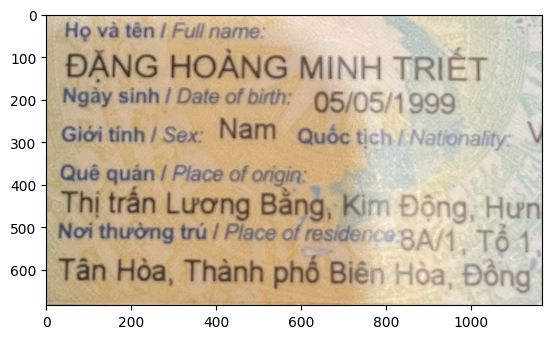

vầ tên / Full name:
ĐẶNG HOANG MINH TRIÉT
Ngày sinh / Date of bỉrth;
05/05/1999
Giới tinh / Sex:
Nam
Quôc tịch
Nationality-
Quê quán / Place of origin:
Thị trấn Lương
Kim
Hưn
Nơi thường trú / Place of residenco 8A/1
Tố 1
Tân Hòa, Thành
Biên Hòa
Họ
Bẳng ;
Đông
phố
Đông


In [20]:
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
from pillow_heif import register_heif_opener
import easyocr


register_heif_opener()
def ocr_vietnamese_text(image_path):
    # Mở ảnh sử dụng Pillow
    img = Image.open(image_path)

    # Chuyển đổi ảnh sang định dạng PNG (nếu không phải là PNG)
    if img.format != "PNG":
        img = img.convert("RGB")  # Chuyển đổi sang ảnh RGB (định dạng phổ biến nhất)
        png_image_path = "converted_image.png"
        img.save(png_image_path, format="PNG")  # Lưu ảnh dưới dạng PNG

    else:
        png_image_path = image_path  # Sử dụng ảnh gốc nếu đã là định dạng PNG
    plt.imshow(img)
    plt.show()
    # Sử dụng Tesseract OCR để chuyển đổi ảnh thành văn bản
    text = pytesseract.image_to_string(png_image_path, lang='vie')

    return text

def ocr_vietnamese_and_english(image_path):
    # Đường dẫn đến ảnh
    reader = easyocr.Reader(['en', 'vi'])  # Chỉ định ngôn ngữ cần nhận dạng
    img = Image.open(image_path)
    # Chuyển đổi ảnh sang định dạng PNG (nếu không phải là PNG)
    if img.format != "PNG":
        img = img.convert("RGB")  # Chuyển đổi sang ảnh RGB (định dạng phổ biến nhất)
        png_image_path = "converted_image.png"
        img.save(png_image_path, format="PNG")  # Lưu ảnh dưới dạng PNG

    else:
        png_image_path = image_path  # Sử dụng ảnh gốc nếu đã là định dạng PNG
    plt.imshow(img)
    plt.show()

    # Nhận dạng văn bản từ ảnh
    result = reader.readtext(png_image_path)

    # Tạo một đoạn văn bản từ kết quả nhận dạng
    text = '\n'.join([entry[1] for entry in result])

    return text

# Đường dẫn đến ảnh cần chuyển đổi
image_path = "/content/drive/MyDrive/Recommandation System/IMG_9218.heic"

# Sử dụng hàm ocr_vietnamese_text để chuyển đổi ảnh sang văn bản
# text = ocr_vietnamese_text(image_path)
text = ocr_vietnamese_and_english(image_path)

# In văn bản được chuyển đổi
print(text)

# **Test 080424**

In [135]:
import pandas as pd

In [141]:
def read_data(file_path):
    """
       params:
           file_path: 文件路径
       return:
           data: 读取的数据列表，每行一条样本

    """
    data = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            # 过长的评论文本会超出io限制报错。 暂时忽略
            try:
                # 字符串预处理
                # 布尔替换成python的习惯
                str_text = line.replace("true", "True")
                str_text = str_text.replace("false", "False")
                # 转成字典形式
                raw_sample = eval(str_text)
                data.append([raw_sample['reviewerID'],
                             raw_sample['asin'],
                             raw_sample['overall'],
                             raw_sample['reviewText']])
            except:
                pass
    return data

def remove_duplicate_rows(df):
    # Loại bỏ các hàng trùng lặp dựa trên cột 'reviewText'
    df = df.drop_duplicates(subset=['reviewText'])
    return df

In [188]:
data = read_data("/home/triet/ComputerScience_K32/Recommendation_System/DeepCGSR_triet/data/raw/Beauty_5.json")
data_df = pd.DataFrame(data)
data_df.columns = ['reviewerID', 'asin', 'overall', 'reviewText']
# Loại bỏ các dòng có reviewText trùng lặp
data_df = remove_duplicate_rows(data_df)
data_rating = data_df["overall"].tolist()
data_review = data_df["reviewText"].tolist()

In [189]:
print(data_rating)

[1.0, 3.0, 4.0, 2.0, 3.0, 5.0, 1.0, 2.0, 2.0, 3.0, 3.0, 1.0, 5.0, 1.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 3.0, 3.0, 4.0, 2.0, 4.0, 5.0, 2.0, 2.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 1.0, 1.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 2.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 2.0, 1.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 1.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 2.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 5.0, 4.0, 3.0, 3.0, 5.0, 2.0, 5.0, 5.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 1.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 2.0, 5.0, 4.0, 3.0, 2.0, 1.0, 4.0, 2.0, 2.0, 5.0, 2.0, 5.0, 5.0, 1.0, 1.0, 5.0, 3.0, 2.0, 3.0, 4.0, 3.0, 3.0, 5.0,

In [190]:
import pandas as pd
# step01:
def defineRating(data_rating):
  T_v = []
  for rating in data_rating:
    if rating >= 4:
      T_v.append(1)
    else:
      T_v.append(-1)
  return T_v

T_v = defineRating(data_rating)

# Define the data for the dataframe
data = {'id': range(len(T_v)), 'T_v': T_v}

# Create the dataframe
df_rating = pd.DataFrame(data)

# Print the dataframe
print(df_rating)


            id  T_v
0            0   -1
1            1   -1
2            2    1
3            3   -1
4            4   -1
...        ...  ...
198409  198409    1
198410  198410    1
198411  198411    1
198412  198412    1
198413  198413    1

[198414 rows x 2 columns]


In [191]:
# Thêm vào dataframe df_rating cột C_v
df_rating['overall'] = data_rating
df_rating['reviewText'] = data_review

print(df_rating)

            id  T_v  overall  \
0            0   -1      1.0   
1            1   -1      3.0   
2            2    1      4.0   
3            3   -1      2.0   
4            4   -1      3.0   
...        ...  ...      ...   
198409  198409    1      5.0   
198410  198410    1      5.0   
198411  198411    1      5.0   
198412  198412    1      5.0   
198413  198413    1      5.0   

                                               reviewText  
0       Very oily and creamy. Not at all what I expect...  
1       This palette was a decent price and I was look...  
2       The texture of this concealer pallet is fantas...  
3       I really can't tell what exactly this thing is...  
4       It was a little smaller than I expected, but t...  
...                                                   ...  
198409  Just a little dab of this shea butter should b...  
198410  This shea butter is completely raw and unrefin...  
198411  The skin is the body's largest organ and it ab...  
198412  I have 

In [192]:
from textblob import TextBlob


# Define function to extract a string's sentiment
find_sentiment = lambda text: TextBlob(text).sentiment[0]
# Create new column in dataframe
C_v = data_df["reviewText"].apply(find_sentiment)



In [193]:
# Thêm vào dataframe df_rating cột C_v
df_rating['C_v'] = C_v
print(df_rating[df_rating['id'] == 98])

    id  T_v  overall                                         reviewText  \
98  98    1      5.0  Best hand cream I've ever used, and I NEVER us...   

         C_v  
98  0.164045  


In [194]:
# step02:
import math


def euclidean_distance(p1, p2):
  distance = math.sqrt((p2 - p1)**2)
  return distance
V_d = []
for ti, ci in zip(T_v, C_v):
  V_d.append(euclidean_distance(ti, ci))
  # V_d.append((ti + ci)/2)

In [195]:
# Thêm vào dataframe df_rating cột V_d
df_rating['V_d'] = V_d
print(df_rating)

            id  T_v  overall  \
0            0   -1      1.0   
1            1   -1      3.0   
2            2    1      4.0   
3            3   -1      2.0   
4            4   -1      3.0   
...        ...  ...      ...   
198409  198409    1      5.0   
198410  198410    1      5.0   
198411  198411    1      5.0   
198412  198412    1      5.0   
198413  198413    1      5.0   

                                               reviewText       C_v       V_d  
0       Very oily and creamy. Not at all what I expect... -0.300000  0.700000  
1       This palette was a decent price and I was look...  0.033333  1.033333  
2       The texture of this concealer pallet is fantas...  0.237333  0.762667  
3       I really can't tell what exactly this thing is...  0.225000  1.225000  
4       It was a little smaller than I expected, but t...  0.145313  1.145312  
...                                                   ...       ...       ...  
198409  Just a little dab of this shea butter should b.

In [196]:
# step03:
S_pos = []
S_neg = []

i = 0
for r in data_rating:
  if r >= 4:
    S_pos.append([i, r, V_d[i]])
  else:
    S_neg.append([i, r, V_d[i]])
  i = i + 1

print(len(S_pos))
print(len(S_neg))
element = None
i = 0
for item in S_pos:
    if item[0] == 25:
        element = item
        break
    i = i + 1
# for item in S_neg:
#     if item[0] == 25:
#         element = item
#         break
print(S_pos[17])
print(element)



154195
44219
[34, 5.0, 0.375]
None


In [197]:
#step04:

def calculation_IQR(S, V_d, flag='pos'):
  # Sắp xếp dữ liệu
  sorted_data = sorted(V_d)

  # Tính Q1 và Q3
  q1_index = int(len(sorted_data) * 0.25)
  q3_index = int(len(sorted_data) * 0.75)
  Q1 = sorted_data[q1_index]
  Q3 = sorted_data[q3_index]

  # Tính IQR
  IQR = Q3 - Q1

  # Tính F_L và F_U
  F_L = Q1 - 1.5 * IQR
  F_U = Q3 + 1.5 * IQR

  if flag == 'pos':
    if F_L < 0:
      O_s =  Q3 + IQR
    else:
      O_s = F_U - IQR*F_L
  else:
    if F_U > 2:
      O_s = Q1 - IQR
    else:
      O_s = Q3 - IQR*F_U

  return O_s

O_Spos = calculation_IQR(S_pos, V_d, flag = 'pos')
O_Sneg = calculation_IQR(S_neg, V_d, flag = 'neg')

print(O_Spos)
print(O_Sneg)

1.331535813148789
0.5560115532487504


In [198]:
#step05:


# S_pos: danh sách các chỉ số của các phần tử thuộc S+
# S_neg: danh sách các chỉ số của các phần tử thuộc S-
# VD: danh sách các giá trị của biến VD
# OS_pos: giá trị OS+ như trong mã script
# OS_neg: giá trị OS- như trong mã script

# Khởi tạo danh sách O+ và O-
O_pos = [0] * len(S_pos)
O_neg = [0] * len(S_neg)

# print(S_pos)
# print(S_neg)
count = 0
# Điều chỉnh danh sách O+ và O- theo điều kiện trong mã script
for i, ri in enumerate(S_pos):
  print(i, ri)
  if ri[2] >= O_Spos:
    O_pos[i] = 'yes'
    count += 1
  else:
    O_pos[i] = 'no'

for i, ri in enumerate(S_neg):
    if ri[2] <= O_Sneg:
      O_neg[i] = 'yes'
      count += 1
    else:
      O_neg[i] = 'no'

print(count)
# In ra kết quả
# print("O+:", O_pos)
# print("O-:", O_neg)


0 [2, 4.0, 0.7626666666666666]
1 [5, 5.0, 0.6011111111111112]
2 [12, 5.0, 0.5333333333333334]
3 [14, 5.0, 1.0]
4 [16, 5.0, 1.0166666666666666]
5 [17, 4.0, 0.8729166666666667]
6 [19, 5.0, 0.7638888888888888]
7 [20, 5.0, 0.09999999999999998]
8 [21, 5.0, 0.41666666666666663]
9 [22, 5.0, 0.8226620628720238]
10 [23, 5.0, 0.5]
11 [24, 5.0, 0.6422751322751322]
12 [26, 5.0, 0.7327272727272727]
13 [27, 5.0, 0.4018518518518519]
14 [28, 5.0, 0.6709649122807018]
15 [31, 4.0, 0.8461805555555556]
16 [33, 4.0, 0.844905869324474]
17 [34, 5.0, 0.375]
18 [37, 5.0, 0.9026041666666667]
19 [38, 5.0, 0.5]
20 [39, 5.0, 0.46799999999999997]
21 [44, 4.0, 1.0022435897435897]
22 [45, 4.0, 0.9161764705882353]
23 [46, 5.0, 0.88]
24 [47, 4.0, 0.8818724071067822]
25 [48, 5.0, 1.0313333333333334]
26 [49, 5.0, 0.625]
27 [50, 4.0, 0.86]
28 [53, 4.0, 0.605]
29 [54, 4.0, 0.5583333333333333]
30 [57, 5.0, 1.0285714285714285]
31 [58, 5.0, 0.6916666666666667]
32 [59, 5.0, 0.7327380952380953]
33 [60, 5.0, 0.7805555555555556]


In [199]:
df = pd.DataFrame(S_pos, columns=['id', 'rating', 'V_d'])
df['O_pos'] = O_pos
#In ra các phần tử có giá trị 'yes'
print(df[df['O_pos'] == 'yes'])


            id  rating       V_d O_pos
123        173     5.0  1.350000   yes
543        747     5.0  2.000000   yes
1557      2063     5.0  1.350000   yes
2199      2966     5.0  1.677083   yes
2399      3245     4.0  1.406901   yes
...        ...     ...       ...   ...
145721  188553     5.0  1.550000   yes
148151  191662     5.0  1.408333   yes
151186  195166     4.0  1.500000   yes
151235  195216     5.0  2.000000   yes
152969  197147     4.0  1.400000   yes

[247 rows x 4 columns]


In [200]:
#step06:
# Hàm toggle để đảo ngược giá trị của một biến
def toggle(value):
  if value == -1:
    return 1
  else:
    return -1

# Khởi tạo danh sách TV với giá trị False cho mỗi phần tử
TV_new = T_v.copy()

count_1 = 0
for i, ri in enumerate(S_pos):
    if O_pos[i] == 'yes':
      count_1 += 1
      TV_new[ri[0]] = toggle(T_v[ri[0]])

for i, ri in enumerate(S_neg):
    if O_neg[i] == 'no':
      count_1 += 1
      TV_new[ri[0]] = toggle(T_v[ri[0]])

# print(TV_new)
# Tạo danh sách D* bằng cách nối S+ và S-
print(count_1)
# D_star = S_pos + S_neg

779


In [201]:
# Thêm vào dataframe df_rating cột TV_new
df_rating['TV_new'] = TV_new
print(df_rating)

            id  T_v  overall  \
0            0   -1      1.0   
1            1   -1      3.0   
2            2    1      4.0   
3            3   -1      2.0   
4            4   -1      3.0   
...        ...  ...      ...   
198409  198409    1      5.0   
198410  198410    1      5.0   
198411  198411    1      5.0   
198412  198412    1      5.0   
198413  198413    1      5.0   

                                               reviewText       C_v       V_d  \
0       Very oily and creamy. Not at all what I expect... -0.300000  0.700000   
1       This palette was a decent price and I was look...  0.033333  1.033333   
2       The texture of this concealer pallet is fantas...  0.237333  0.762667   
3       I really can't tell what exactly this thing is...  0.225000  1.225000   
4       It was a little smaller than I expected, but t...  0.145313  1.145312   
...                                                   ...       ...       ...   
198409  Just a little dab of this shea butter sh

In [202]:
# Tạo DataFrame mới để lưu các hàng thỏa mãn điều kiện
outliner = pd.DataFrame(columns=df_rating.columns)

# Lặp qua các hàng của DataFrame df_rating
for index, row in df_rating.iterrows():
    if row['TV_new'] != row['T_v']:
        # Thêm hàng vào DataFrame outliner
        outliner.loc[len(outliner)] = row

# In ra DataFrame outliner
print(outliner)

# Lưu DataFrame outliner vào file CSV
outliner.to_csv('/home/triet/ComputerScience_K32/Recommendation_System/DeepCGSR_triet/outliner.csv', index=False)

         id T_v overall                                         reviewText  \
0       173   1     5.0  I have been using this brand for over 10 years...   
1       420  -1     2.0  It has sylisic Acid in it..It's really hard on...   
2       747   1     5.0  I got this tip from a co-worker who's daughter...   
3      1393  -1     3.0  Er ... this is $6.75 for One Bottle?  I can ge...   
4      1707  -1     3.0  weird smell and hate the smell.. almost took b...   
..      ...  ..     ...                                                ...   
774  191662   1     5.0  I haven't tried this product yet, but once my ...   
775  192353  -1     1.0                        Sadly it didn't work for me   
776  195166   1     4.0  Ordered once before and got wrong item..sent b...   
777  195216   1     5.0  Why go to a spa and pay an outrageous amount f...   
778  197147   1     4.0  It was efficient and made my hair feel silky a...   

          C_v       V_d TV_new  
0       -0.35      1.35     -1

In [203]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch

# Load pre-trained model and tokenizer for Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'  # Example model, you can choose other pre-trained models
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)




In [208]:
#Define the text to analyze
text = "I love the product"
def sentiment_analysis(text, model, tokenizer):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt')

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted probabilities for each class
    probs = softmax(outputs.logits, dim=1).squeeze()

    # Convert the probabilities to human-readable labels
    labels = [1, 2, 3, 4, 5]  # For this model, it predicts star ratings
    predicted_label = labels[torch.argmax(probs).item()]
    # print(predicted_label)
    return predicted_label

# Print the result
print("Predicted sentiment:", sentiment_analysis(text, model, tokenizer))
print("Predicted sentiment:", torch.sigmoid(outputs.logits).squeeze()[1].item())
# print("Confidence:", probs[torch.argmax(probs)].item())

Predicted sentiment: 5
Predicted sentiment: 0.09789914637804031


In [209]:

predict_rating = df_rating['reviewText'].apply(lambda x: sentiment_analysis(x[:512], model=model, tokenizer=tokenizer))

predict_rating_list = predict_rating.tolist()
predict_rating_list =  defineRating(predict_rating_list)
print(predict_rating_list)

df_rating['predict_rating'] = predict_rating_list
print(df_rating)


In [ ]:
print(sentiment_analysis("The color pattern and fit is what I liked the most what I liked the least is that they are not easy to clean and stains do not come out very easy or at all", model, tokenizer))

3


In [ ]:
i = 0

for row in df_rating.itertuples():
    if row.predict_rating != row.T_v:
        i += 1
        print(row.predict_rating)
        print(row.T_v)
        print(row.overall)
        print(row.reviewText)
        print('------------------------')
print('count: ', i)

# Tạo DataFrame mới để lưu các hàng thỏa mãn điều kiện
outliner = pd.DataFrame(columns=['predict_rating', 'T_v', 'overall', 'reviewText'])
# Lặp qua các hàng của DataFrame df_rating
# Lặp qua các hàng của DataFrame df_rating
for index, row in df_rating.iterrows():
    if row['predict_rating'] != row['T_v']:
        # Thêm hàng vào DataFrame outliner
        outliner.loc[len(outliner)] = row

# In ra DataFrame outliner
print(outliner)

# Lưu DataFrame outliner vào file CSV
outliner.to_csv('/home/triet/ComputerScience_K32/Recommendation_System/DeepCGSR_triet/outliner_bert.csv', index=False)